In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# GNN - Model with count encodings

Here, I train a basic GNN with NAICS links, doing a one-hop model. Batching is used for training, and nodes are sampled at each layer. 

*This script takes about 2 hours on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np

In [3]:
from pathlib import Path
import importlib
import pickle, re

In [4]:
import stellargraph as sg
from stellargraph.layer import HinSAGE
from stellargraph.mapper import HinSAGENodeGenerator

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

import keras
import tensorflow.keras.metrics as km
from keras import initializers
import tensorflow as tf

2024-02-26 21:55:41.558185: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-02-26 21:55:41.558208: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-26 21:55:41.558217: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-26 21:55:41.558255: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-26 21:55:41.558272: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Import Data
Import Stellargraph dataset for training

##### Heterogeneous graph

In [5]:
# Training and validation clients - monitor training on val clients
with open(Path(setup.temp_path).joinpath('23_DATA_stellargraph_train_val.pkl'), 'rb') as fin:
      sba_graph  = pickle.load(fin)

In [6]:
print(sba_graph.info())

StellarGraph: Undirected multigraph
 Nodes: 552875, Edges: 52159047

 Node types:
  LoanNr_ChkDgt: [551635]
    Features: float32 vector, length 11
    Edge types: LoanNr_ChkDgt-loan_naics->NAICS, LoanNr_ChkDgt-loan_sector_naics->NAICS
  NAICS: [1240]
    Features: float32 vector, length 1
    Edge types: NAICS-loan_naics->LoanNr_ChkDgt, NAICS-loan_sector_naics->LoanNr_ChkDgt

 Edge types:
    LoanNr_ChkDgt-loan_sector_naics->NAICS: [51607412]
        Weights: all 1 (default)
        Features: none
    LoanNr_ChkDgt-loan_naics->NAICS: [551635]
        Weights: all 1 (default)
        Features: none


##### Labels

In [7]:
label_data = pd.read_parquet(Path(setup.temp_path).joinpath('20_DATA_label_info.parquet')).sort_index()

## Process labels
Get separate train, test label dataframes.  Also get initial target rate (for metric tracking)

In [8]:
train_labels = label_data[(label_data['dset'] == 'train')] \
    .drop(columns=['dset', 'dset_naics_holdout'], errors='ignore')
val_labels = label_data[label_data['dset'] == 'val'] \
    .drop(columns=['dset', 'dset_naics_holdout'], errors='ignore')
print(f'this graph labels shape {label_data.shape}')
print(f'train labels shape {train_labels.shape}')
print(f'validation labels shape {val_labels.shape}')

this graph labels shape (688081, 2)
train labels shape (425594, 1)
validation labels shape (126041, 1)


In [9]:
vc = train_labels['target'].value_counts(normalize=True)
base_thresh = vc.loc[1]
print(f'target rate: {base_thresh}')

target rate: 0.20307382152943884


## Train

##### Set seeds to setup

In [10]:
# Set some seeds
np.random.seed(16)
tf.random.set_seed(16)
sg.random.set_seed(4345)

##### Node Predictor Generator and "Flows"
Create objects to train on train cases, monitor on validation cases

In [11]:
generator = HinSAGENodeGenerator(sba_graph, batch_size=setup.gnn_batch_size, 
                                 num_samples=setup.gnn_num_samples,
                                 head_node_type='LoanNr_ChkDgt',
                                 seed=2454)

In [12]:
train_gen = generator.flow(train_labels.index, train_labels['target'], shuffle=True)

In [13]:
val_gen = generator.flow(val_labels.index, val_labels['target'], shuffle=False)

##### Create HinSage model (a Keras model)

In [14]:
graphsage_model = HinSAGE(
    layer_sizes=setup.gnn_layer_sizes, 
    activations=setup.gnn_activations,
    generator=generator, bias=True, dropout=setup.gnn_dropout
)

In [15]:
x_inp, x_out = graphsage_model.in_out_tensors()

prediction = layers.Dense(units=1, activation="sigmoid",
                         kernel_initializer=initializers.glorot_uniform(seed=2343),
                         bias_initializer = initializers.Zeros())(x_out) 

/Users/valeriecarey/miniconda3/envs/tf_p38/lib/python3.8/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [16]:
model = Model(inputs=x_inp, outputs=prediction)
optimizer = setup.gnn_optimizer(learning_rate=setup.gnn_learning_rate)
model.compile(
    optimizer=optimizer,
    loss = losses.binary_crossentropy,  
    metrics=[km.AUC(curve='PR'), km.AUC(curve='ROC')],
)

##### Fit model

In [17]:
history = model.fit(
    train_gen, epochs=setup.gnn_epochs, validation_data=val_gen, verbose=2, shuffle=False
)

Epoch 1/20


2024-02-26 21:58:08.619321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-26 22:06:42.293137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13300/13300 - 662s - loss: 0.4762 - auc: 0.3035 - auc_1: 0.6644 - val_loss: 0.4684 - val_auc: 0.3320 - val_auc_1: 0.6948 - 662s/epoch - 50ms/step
Epoch 2/20
13300/13300 - 517s - loss: 0.4730 - auc: 0.3132 - auc_1: 0.6734 - val_loss: 0.4674 - val_auc: 0.3339 - val_auc_1: 0.6955 - 517s/epoch - 39ms/step
Epoch 3/20
13300/13300 - 1339s - loss: 0.4722 - auc: 0.3146 - auc_1: 0.6754 - val_loss: 0.4681 - val_auc: 0.3350 - val_auc_1: 0.6997 - 1339s/epoch - 101ms/step
Epoch 4/20
13300/13300 - 1329s - loss: 0.4715 - auc: 0.3176 - auc_1: 0.6777 - val_loss: 0.4664 - val_auc: 0.3381 - val_auc_1: 0.6975 - 1329s/epoch - 100ms/step
Epoch 5/20
13300/13300 - 1511s - loss: 0.4708 - auc: 0.3192 - auc_1: 0.6791 - val_loss: 0.4665 - val_auc: 0.3389 - val_auc_1: 0.6992 - 1511s/epoch - 114ms/step
Epoch 6/20
13300/13300 - 2235s - loss: 0.4706 - auc: 0.3205 - auc_1: 0.6799 - val_loss: 0.4647 - val_auc: 0.3422 - val_auc_1: 0.7043 - 2235s/epoch - 168ms/step
Epoch 7/20
13300/13300 - 2803s - loss: 0.4705 - auc: 0.32

In [18]:
# Tensorflow save format to work around issue 
# https://github.com/tensorflow/tensorflow/issues/46659
model.save(Path(setup.temp_path).joinpath('24_DATA_model.keras'), save_format='tf')

## History Plots

In [19]:
this_history_df = pd.DataFrame(history.history)

In [20]:
# Rename columns
try:
    this_history_df.columns = ['_'.join(c.split('_')[0:-1])  \
                               if re.search(r'_\d+$', c) else c for c in this_history_df.columns]
except:
    pass
try:
    cur_col = list(this_history_df.columns)
    this_history_df.columns = [cur_col[0]] + \
        [f'{cur_col[i]}_roc'  if (cur_col[i] == cur_col[i-1]) and 'auc'in cur_col[i] \
         else cur_col[i] for i in range(1, len(cur_col))]
except:
    pass

In [21]:
this_history_df.columns

Index(['loss', 'auc', 'auc_roc', 'val_loss', 'val_auc', 'val_auc_roc'], dtype='object')

In [22]:
this_history_df.to_csv(Path(setup.temp_path).joinpath('24_REPORT_fit_history.csv'))

<Axes: >

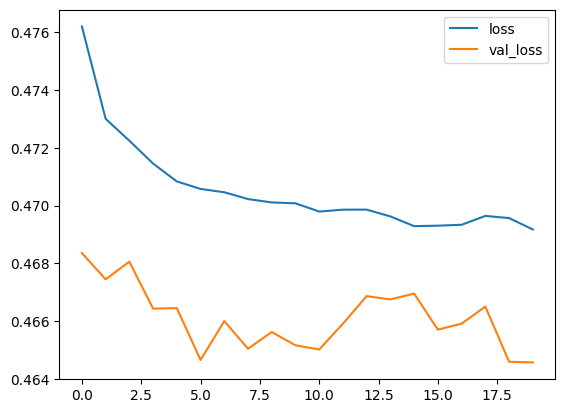

In [23]:
this_history_df[['loss', 'val_loss']].plot()

<Axes: >

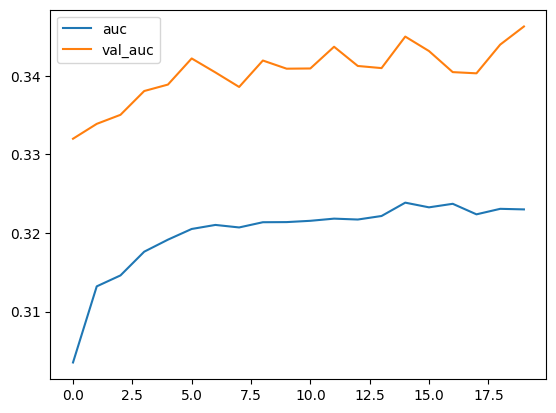

In [24]:
this_history_df[['auc', 'val_auc']].plot()

## Metrics
Get basic metrics for the fitting graph.  Final metrics will be obtained on a graph containing the test nodes later

In [25]:
val_metrics = model.evaluate(val_gen)

3939/3939 [==============================] - 98s 25ms/step - loss: 0.4646 - auc: 0.3450 - auc_1: 0.7070


In [26]:
train_metrics = model.evaluate(train_gen)

13300/13300 [==============================] - 1230s 93ms/step - loss: 0.4630 - auc: 0.3409 - auc_1: 0.7037


In [27]:
metrics = pd.concat([pd.DataFrame(dict(zip(model.metrics_names, [[t] for t in val_metrics]))),
                         pd.DataFrame(dict(zip(model.metrics_names, [[t] for t in train_metrics])))],
                        keys=['val', 'train'])
metrics.to_csv(Path(setup.temp_path).joinpath('24_REPORT_train_metrics.csv'), index=True)
metrics

,,loss,auc,auc_1
val,0,0.464609,0.344996,0.706971
train,0,0.462990,0.340895,0.703745
